# Table of Contents
 <p><div class="lev1"><a href="#Data-Dashboard-library/plugin-concept"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Dashboard library/plugin concept</a></div><div class="lev2"><a href="#Propose"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Propose</a></div><div class="lev3"><a href="#Data-information"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Data information</a></div><div class="lev3"><a href="#Data-cleaning"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Data cleaning</a></div><div class="lev3"><a href="#Data-visualization"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Data visualization</a></div><div class="lev1"><a href="#Source"><span class="toc-item-num">2&nbsp;&nbsp;</span>Source</a></div><div class="lev2"><a href="#Initializing"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Initializing</a></div><div class="lev2"><a href="#Summarized-data-functions"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Summarized data functions</a></div><div class="lev2"><a href="#DataAnalysisWidget"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>DataAnalysisWidget</a></div><div class="lev2"><a href="#Test"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Test</a></div><div class="lev3"><a href="#Get-the-data"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Get the data</a></div><div class="lev3"><a href="#Prepare-the-data"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Prepare the data</a></div><div class="lev2"><a href="#Test"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Test</a></div><div class="lev3"><a href="#Quick-tests"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span>Quick tests</a></div><div class="lev3"><a href="#Interactive-Data-Analysis-Chart-Test"><span class="toc-item-num">2.5.2&nbsp;&nbsp;</span>Interactive Data Analysis Chart Test</a></div>

# Data Dashboard library/plugin concept

## Propose

The propose of this library/plugin is to allow the data analysis process more 
easy and automatic.

The library will join some methods to help the data manipulation, data cleaning 
and data visualization.

### Data information

When a dataframe were selected, the library will show some information about the
dataframe, such as:

* total of attributes;
* total of instances;
* type of each attributes;
* total of NaN values for each attribute;

### Data cleaning

To improve the user's experience, the user should cleaning and prepare the data 
before call graphical functions.

### Data visualization

Data visualization is divided into 2 parts: the first one is the summary about
the data, as described at section 1.1.1; the second one are graphical summaries.

The graphical summaries is composed by 2 sections: the first one is a interactive 
parameterized chart when the user can chose its fields; the second one is a 
composed chart when the user can see all fields combined with a specific field.


# Source

## Initializing

**Requirements:**

* IPython
* ipywidgets;
* matplotlib;
* numpy;
* pandas;
* textwrap
* traceback

In [1]:
from IPython.display import display, HTML
from ipywidgets import widgets
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import qgrid  # https://github.com/quantopian/qgrid
# import statsmodels.api as sm
import textwrap
import traceback

%matplotlib notebook

In [2]:
def str2enum(data: pd.DataFrame) -> (pd.DataFrame, dict):
    enums = {}
    data = data.copy()
    for k in data.keys():
        if data[k].dtype == object:
            enums[k] = []
            for i, v in enumerate(set(data[k])):
                enums[k].append(v)
                data[k].replace(v, i, inplace=True)
    return data, enums

## Summarized data functions

In [3]:
def get_info(data: pd.DataFrame):
    """
    
    """   
    # types
    df = pd.DataFrame(data.dtypes).rename(columns={0: 'Types'})
    
    # set
    df = pd.merge(
        df, pd.DataFrame(
            data.apply(lambda se : str(sorted(set(se.dropna())))[:1000])
        ).rename(columns={0: 'Set Values'}),
        left_index=True, right_index=True
    )
    
    # total observations
    df = pd.merge(
        df, pd.DataFrame(
            data.count()
        ).rename(columns={0: '# Observations'}),
        left_index=True, right_index=True
    )
    
    # total of nan
    df = pd.merge(
        df, pd.DataFrame(data.isnull().sum()).rename(columns={0: '# NaN'}),
        left_index=True, right_index=True
    )
    return df


def process_query(
    data: pd.DataFrame, field_reference: [str], field_comparison: [str]
) -> pd.DataFrame:
    """

    """
    labels_reference = []
    labels = []

    if not (field_comparison and field_reference):
        return data

    _data = data[field_reference].copy()
    for f in field_comparison+field_reference:
        # create separated fields for categorical data
        if isinstance(data[f].dtype.type(), np.number):
            _data[f], _ = pd.cut(data[f].copy(), bins=5, retbins=True)
            if f in field_reference:
                labels_reference += [f]
        else:
            _labels = list(set(data[f]))
            labels += _labels

            if f in field_reference:
                labels_reference.append(f)
                break

            for l in labels:
                _data[l] = (data[f] == l).replace(False, np.nan)
    return _data.groupby(by=labels_reference).count()

## DataAnalysisWidget

In [4]:
class DataAnalysisWidget:
    def __init__(
        self, data: pd.DataFrame,
        field_reference: str, field_comparison: str,
    ):
        self.data = data
        self.data_info = get_info(self.data)
        self._data = None
        self.ax = None
        self.field_reference = field_reference
        self.field_comparison = field_comparison

        self.w_message_box = widgets.HTML()
        self.w_info_box = widgets.HTML()
        self.w_table_box = widgets.HTML()

        self.w_fields_comparison = widgets.SelectMultiple(
            description='Select the fields of aggregation:',
            options=[i for i in self.data.keys()],
            selected_labels=[field_comparison]
        )

        self.w_fields_reference = widgets.Dropdown(
            description='Select the field of reference:',
            options=[i for i in self.data.keys()],
            selected_label=field_reference
        )

        self.w_fields_reference.padding = 2
        self.w_fields_comparison.padding = 2
        self.w_btn_query = widgets.Button(description="process query")
        self.w_btn_query.on_click(self.query_observe_callback())

    def make_chart(self):
        """
        Ex:
        k = ['Sex', 'Survived']
        df[k].groupby(by='Sex').sum()

        """
        self.ax.cla()

        self.w_message_box.margin = 0
        self.w_message_box.value = ''

        try:
            self._data.plot.bar(ax=self.ax, stacked=True)

            plt.grid(True)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.draw()
        except:
            t = '<br/>'.join(textwrap.wrap(traceback.format_exc(), 80))
            self.w_message_box.value = t
            self.w_message_box.margin = 30

    def make_datatable(self):
        """
        Ex:
        k = ['Sex', 'Survived']
        df[k].groupby(by='Sex').sum()

        """
        self.w_message_box.margin = 0
        self.w_message_box.value = ''
        
        self.w_info_box.value = self.data_info.to_html()

        self.w_table_box.value = ''

        #if fields and ref_field:
        try:
            self.w_table_box.value = self._data.to_html()
        except:
            t = '<br/>'.join(textwrap.wrap(traceback.format_exc(), 80))
            self.w_message_box.value = t
            self.w_message_box.margin = 30

    def query_observe_callback(self):
        def callback(btn=None):
            fields = list(self.w_fields_comparison.selected_labels)
            ref_field = [self.w_fields_reference.selected_label]
            
            self._data = process_query(
                data=self.data, 
                field_reference=ref_field, 
                field_comparison=fields
            )
            
            self.make_chart()
            self.make_datatable()
        return callback
    
    def __repr__(self):
        # display chart
        self.ax = plt.figure().gca()
        plt.show()

        # display objects
        display(self.w_message_box)
        display(self.w_info_box)
        display(self.w_fields_reference)
        display(self.w_fields_comparison)
        display(widgets.HBox((self.w_btn_query,)))
        display(self.w_table_box)
        self.query_observe_callback()()
        return ''

## Test

### Get the data

In [5]:
original_data = pd.read_csv('data/train.csv')
original_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Prepare the data

In [6]:
# df, emums = str2enum(data)
df = original_data.copy()

# Survived field
i_died = df.Survived.astype(float)==0.0
i_survived = df.Survived.astype(float)==1.0
df.loc[i_died, 'Survived'] = 'Died'
df.loc[i_survived, 'Survived'] = 'Survived'


# Pclass field
i_pc1 = df.Pclass.astype(float)==1.0
i_pc2 = df.Pclass.astype(float)==2.0
i_pc3 = df.Pclass.astype(float)==3.0

df.loc[i_pc1, 'Pclass'] = 'Class1'
df.loc[i_pc2, 'Pclass'] = 'Class2'
df.loc[i_pc3, 'Pclass'] = 'Class3'

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,Died,Class3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,Survived,Class1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,Survived,Class3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,Survived,Class1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,Died,Class3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
display(get_info(df))

,Types,Set Values,# Observations,# NaN
PassengerId,int64,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",891,0
Survived,object,"['Died', 'Survived']",891,0
Pclass,object,"['Class1', 'Class2', 'Class3']",891,0
Name,object,"['Abbing, Mr. Anthony', 'Abbott, Mr. Rossmore ...",891,0
Sex,object,"['female', 'male']",891,0
Age,float64,"[0.42, 0.67, 0.75, 0.83, 0.92, 1.0, 2.0, 3.0, ...",714,177
SibSp,int64,"[0, 1, 2, 3, 4, 5, 8]",891,0
Parch,int64,"[0, 1, 2, 3, 4, 5, 6]",891,0
Ticket,object,"['110152', '110413', '110465', '110564', '1108...",891,0
Fare,float64,"[0.0, 4.0125, 5.0, 6.2375, 6.4375, 6.45, 6.495...",891,0


## Test

### Quick tests

In [8]:
# numerical type
ref_field = ['Age']
field = ['Survived']
labels = []

_data = df[ref_field].copy()

for f in field+ref_field:
    # create separated fields for categorical data
    if isinstance(df[f].dtype.type(), np.number):
        _data[f], _ = pd.cut(_data[f], bins=5, retbins=True)
    else:
        labels += list(set(df[f]))
        for l in labels:
            _data[l] = (df[f] == l).replace(False, np.nan)
        
_data_g = _data.groupby(by=ref_field).count()
qgrid.show_grid(_data_g.head())

<IPython.core.display.Javascript object>


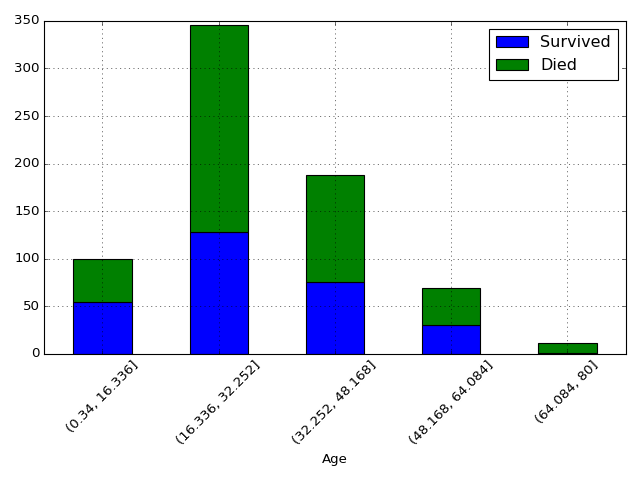

In [9]:
f, ax = plt.subplots()
_data_g.plot.bar(ax=ax, stacked=True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

### Interactive Data Analysis Chart Test

<IPython.core.display.Javascript object>


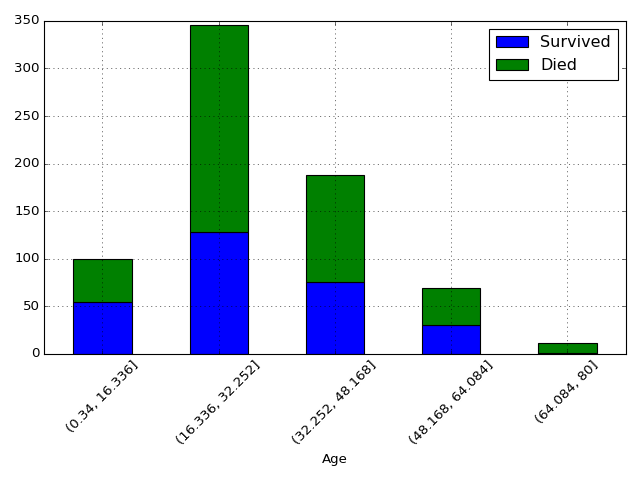

In [11]:
DataAnalysisWidget(
    data=df,
    field_reference='Age',
    field_comparison='Survived'
)